In [ ]:
import torch
import torchaudio
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import wave
import pylab
from google.colab import drive
import librosa
from sklearn.model_selection import train_test_split

drive.mount('/content/gdrive/', force_remount=True)
use_cuda = True
data_directory = '/content/gdrive/My Drive/APS360/APS360 GROUP PROJECT/Data'
train_audiobook_directory = '/content/gdrive/My Drive/APS360/APS360 GROUP PROJECT/Data/AUDIOBOOK FINAL'
train_music_directory = '/content/gdrive/My Drive/APS360/APS360 GROUP PROJECT/Data/MUSIC FINAL'
train_conversation_directory = '/content/gdrive/My Drive/APS360/APS360 GROUP PROJECT/Data/CONVERSATIONS FINAL'
train_tedtalk_directory = '/content/gdrive/My Drive/APS360/APS360 GROUP PROJECT/Data/TED FINAL/trimmedteds'


Mounted at /content/gdrive/


In [ ]:
# Define a custom transformation to crop the audio features
crop_transform = transforms.Compose([
    transforms.RandomCrop((20, 240)),
])

def process_audio_files(data_directory):
    audio_files = os.listdir(data_directory)
    mfcc_features = []

    for file in audio_files:
        file_path = os.path.join(data_directory, file)
        if file.endswith('.wav'):
            audio, sr = librosa.load(file_path, sr=None)  # Load the audio file
            mfcc = librosa.feature.mfcc(y=audio, sr=sr)  # Extract MFCC features

            # Convert the MFCC to a tensor
            mfcc_tensor = torch.from_numpy(mfcc).unsqueeze(0)  # Add a batch dimension

            # Apply the crop transformation
            cropped_mfcc_tensor = crop_transform(mfcc_tensor)


            # Convert the cropped MFCC tensor back to a NumPy array
            cropped_mfcc = cropped_mfcc_tensor.squeeze(0).numpy()

            # Append the cropped MFCC to the list
            mfcc_features.append(cropped_mfcc)

    return mfcc_features

training_audiobook_features = process_audio_files(train_audiobook_directory)
training_music_features = process_audio_files(train_music_directory)
training_tedtalk_features = process_audio_files(train_tedtalk_directory)
training_conversation_features = process_audio_files(train_conversation_directory)


training_audiobook_features = np.array(training_audiobook_features)
training_music_features = np.array(training_music_features)
training_tedtalk_features = np.array(training_tedtalk_features)
training_conversation_features = np.array(training_conversation_features)


In [ ]:
# 0 for audio  1 for music   2 for tedtaLK   3 for conversations
audiobook_labels = np.zeros(len(training_audiobook_features))
music_labels = np.ones(len(training_music_features))
tedtalk_labels = np.full(len(training_tedtalk_features), 2)
conversation_labels = np.full(len(training_conversation_features),3)

# Combine MFCC features and labels
combined_features = np.concatenate((training_audiobook_features, training_music_features, training_tedtalk_features, training_conversation_features), axis=0)
combined_labels = np.concatenate((audiobook_labels, music_labels, tedtalk_labels, conversation_labels), axis=0)

In [ ]:
# Split combined data into training (70%) and a temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    combined_features, combined_labels, test_size=0.3, random_state=10)

# Split the temporary set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=10)

In [ ]:
torch.manual_seed(1)

# Define your model
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape[0], out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=64, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.rnn = nn.RNN(input_size=64*58, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x, _ = self.rnn(x.unsqueeze(1))
        x = x[:, -1, :]
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Define your input shape and create an instance of the model
input_shape = (20, 240)
model = ConvNet(input_shape)

train_accuracies = []
val_accuracies = []

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for inputs, labels in zip(X_train, y_train):
        # Convert inputs and labels to tensors
        inputs = torch.from_numpy(inputs).unsqueeze(0)
        labels = torch.tensor([labels], dtype=torch.long)  #Convert labels to long data type

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Printing prediction
        # print("Label: {}, Prediction: {}".format(labels, outputs))

    # Calculate average training loss and accuracy
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in zip(X_val, y_val):
            # Convert inputs and labels to tensors
            inputs = torch.from_numpy(inputs).unsqueeze(0)
            labels = torch.tensor([labels], dtype=torch.long)  # Convert labels to long data type

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate the loss
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Print the training and validation accuracies
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Accuracy: {train_accuracy*100:.2f}%, Val Accuracy: {val_accuracy*100:.2f}%")

print("Training finished!")

Epoch 1/20: Train Accuracy: 59.62%, Val Accuracy: 65.67%
Epoch 2/20: Train Accuracy: 68.49%, Val Accuracy: 73.95%
Epoch 3/20: Train Accuracy: 77.72%, Val Accuracy: 82.48%
Epoch 4/20: Train Accuracy: 84.62%, Val Accuracy: 87.21%
Epoch 5/20: Train Accuracy: 88.79%, Val Accuracy: 87.21%
Epoch 6/20: Train Accuracy: 89.53%, Val Accuracy: 92.27%
Epoch 7/20: Train Accuracy: 91.46%, Val Accuracy: 93.37%
Epoch 8/20: Train Accuracy: 92.30%, Val Accuracy: 93.76%
Epoch 9/20: Train Accuracy: 93.15%, Val Accuracy: 93.13%
Epoch 10/20: Train Accuracy: 93.08%, Val Accuracy: 93.61%
Epoch 11/20: Train Accuracy: 93.86%, Val Accuracy: 93.53%
Epoch 12/20: Train Accuracy: 94.32%, Val Accuracy: 94.71%
Epoch 13/20: Train Accuracy: 94.49%, Val Accuracy: 94.40%
Epoch 14/20: Train Accuracy: 95.08%, Val Accuracy: 94.24%
Epoch 15/20: Train Accuracy: 95.18%, Val Accuracy: 95.19%
Epoch 16/20: Train Accuracy: 95.52%, Val Accuracy: 95.90%
Epoch 17/20: Train Accuracy: 95.96%, Val Accuracy: 95.82%
Epoch 18/20: Train Accu

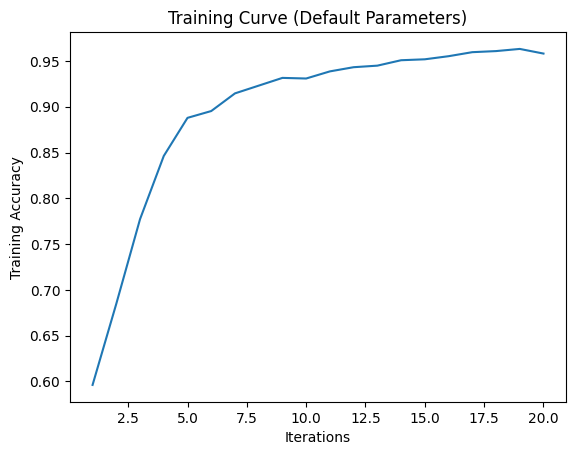

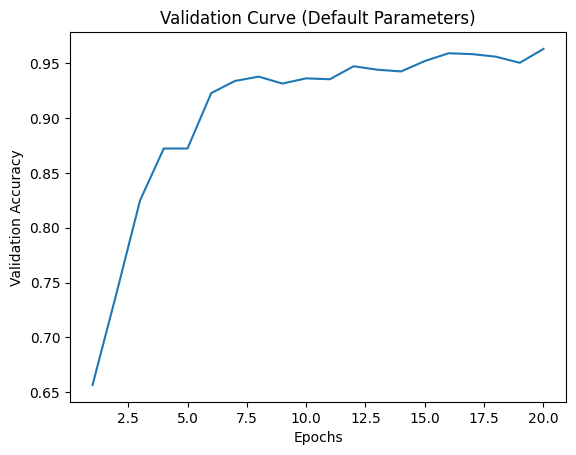

In [ ]:
Iterations = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(Iterations, train_accuracies)
plt.title("Training Curve (Default Parameters)")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(Iterations, val_accuracies)
plt.title("Validation Curve (Default Parameters)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

In [ ]:
# Test loop
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in zip(X_test, y_test):
        # Convert inputs and labels to tensors
        inputs = torch.from_numpy(inputs).unsqueeze(0)
        labels = torch.tensor([labels], dtype=torch.long)  # Convert labels to long data type

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Accumulate the loss
        test_loss += loss.item()

        # Calculate test accuracy
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

# Calculate average test loss and accuracy
test_accuracy = correct_test / total_test

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 95.82%


Category: Audiobook


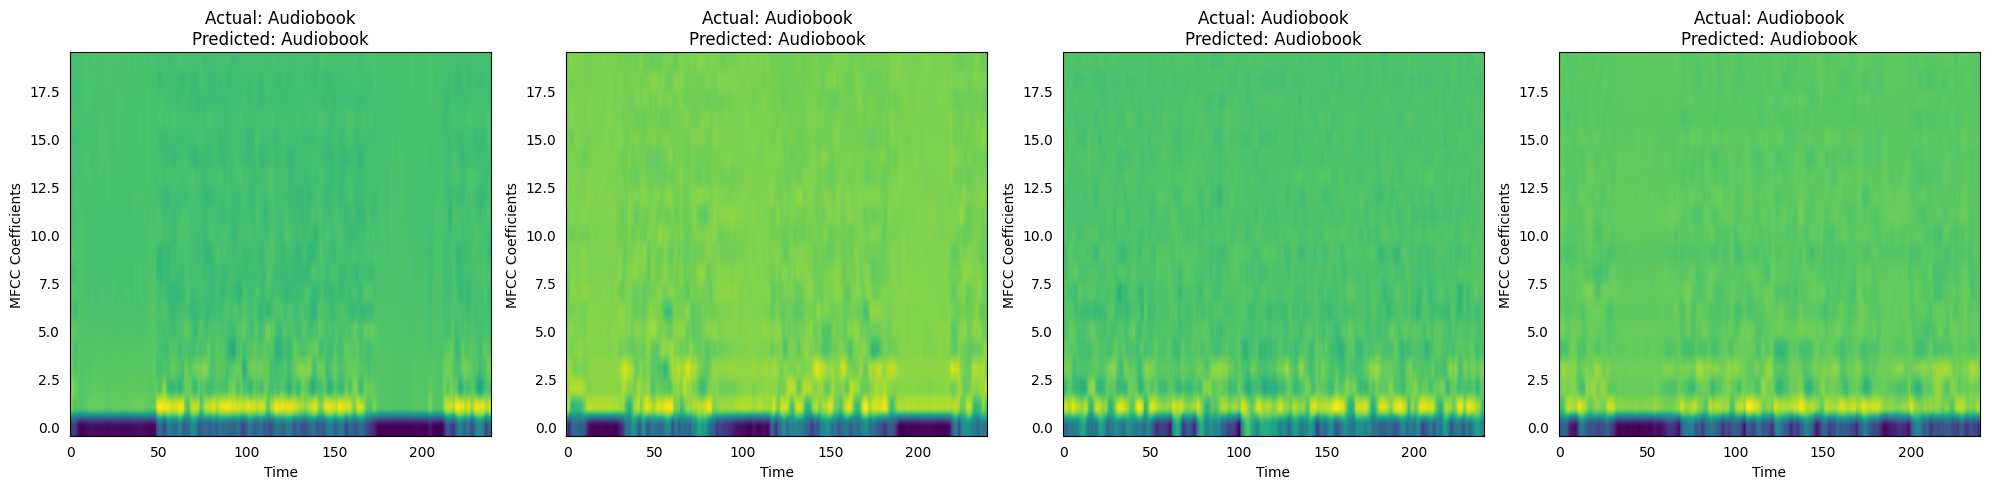

Category: Music


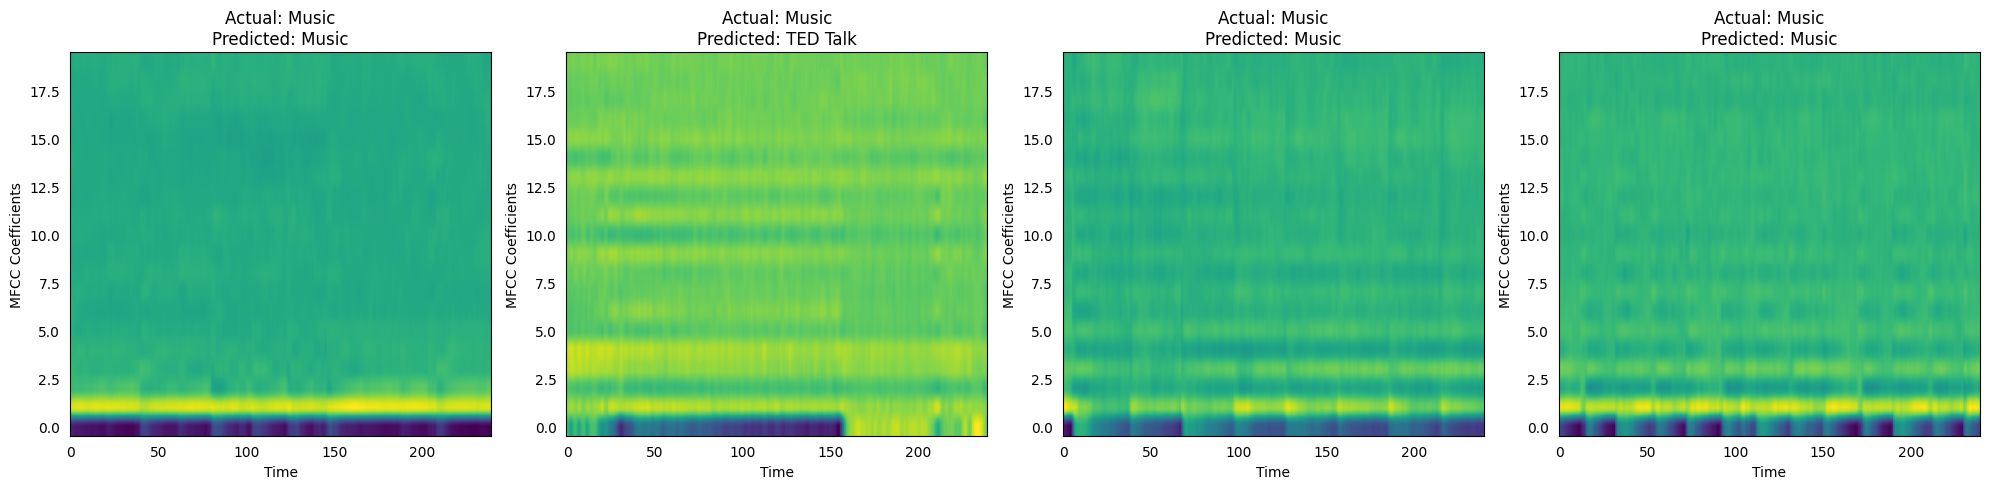

Category: TED Talk


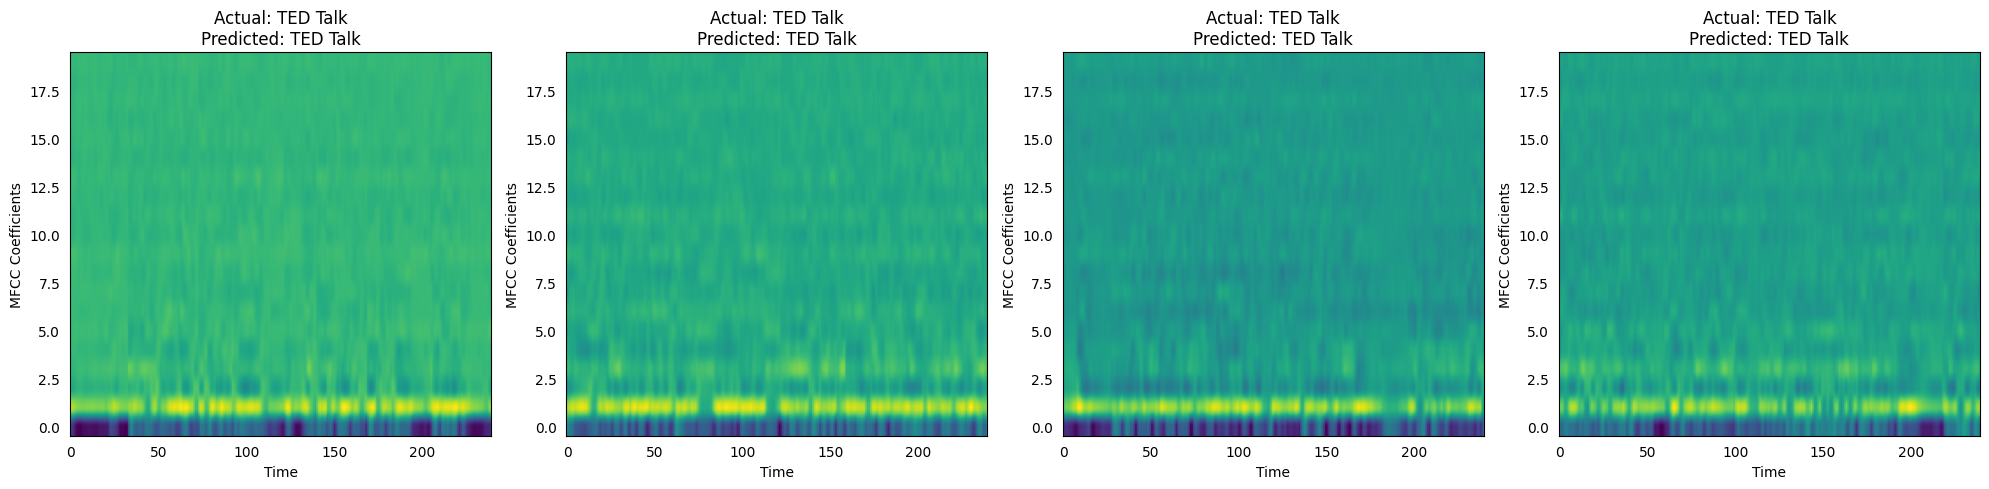

Category: Conversation


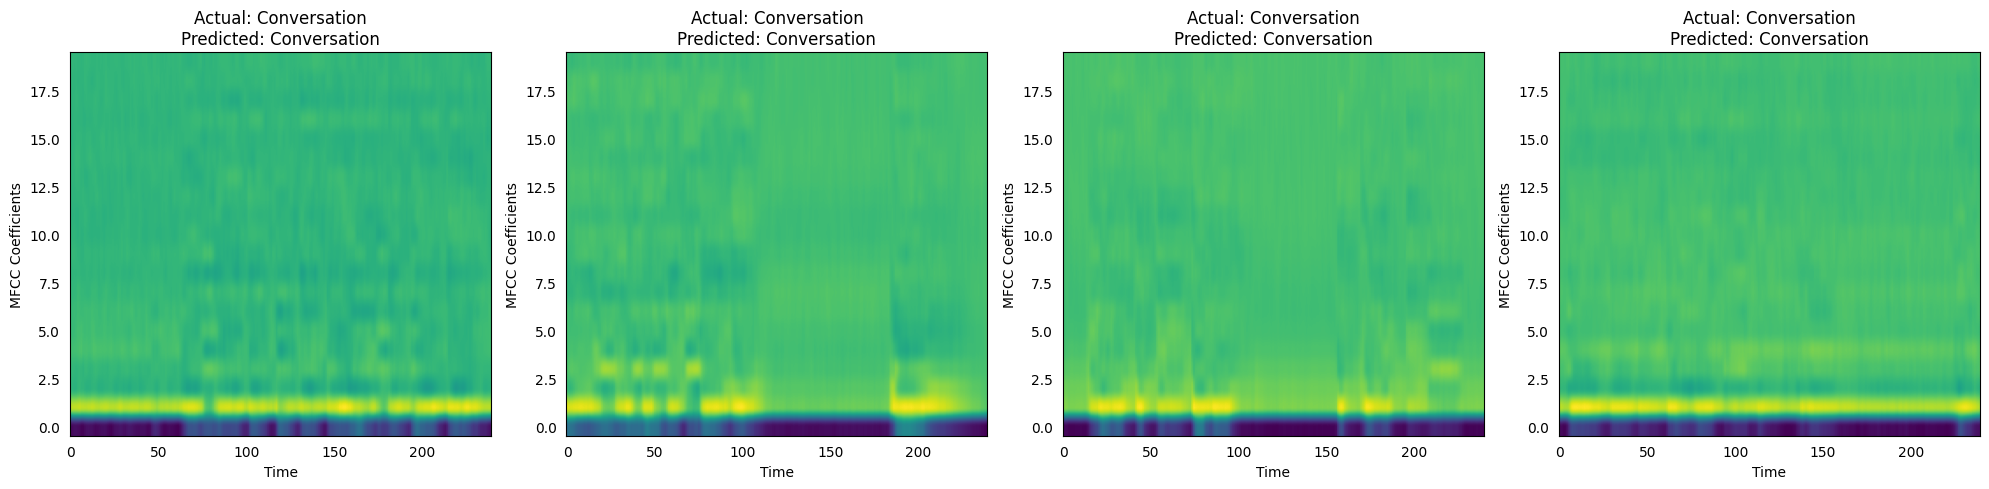

In [ ]:
import random

def get_class_label(class_idx):
    class_labels = ["Audiobook", "Music", "TED Talk", "Conversation"]
    return class_labels[class_idx]

# Test loop
model.eval()

# Collect 4 random samples for each category
sample_indices = {}
for i in range(4):
    category_indices = np.where(y_test == i)[0]
    sample_indices[i] = random.sample(list(category_indices), 4)

with torch.no_grad():
    for class_idx in range(4):
        print(f"Category: {get_class_label(class_idx)}")

        # Create a grid of subplots for each category
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        for idx, sample_idx in enumerate(sample_indices[class_idx]):
            inputs, label = torch.from_numpy(X_test)[sample_idx], torch.from_numpy(y_test)[sample_idx]

            # Convert inputs and label to tensors
            inputs = inputs.unsqueeze(0)

            # Forward pass
            outputs = model(inputs)
            _, predicted_test = torch.max(outputs.data, 1)

            # Get the class label strings for actual and predicted labels
            actual_label = get_class_label(int(label.item()))
            predicted_label = get_class_label(int(predicted_test.item()))

            # Convert the MFCC tensor back to a NumPy array
            mfcc_image = inputs.squeeze(0).numpy()

            # Plot the MFCC image in the corresponding subplot
            axs[idx].imshow(mfcc_image, cmap='viridis', origin='lower', aspect='auto')
            axs[idx].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
            axs[idx].set_xlabel("Time")
            axs[idx].set_ylabel("MFCC Coefficients")
            axs[idx].tick_params(left=False, bottom=False)  # Remove ticks

        plt.tight_layout()
        plt.show()